Dataset: Fashion MINIST : https://www.kaggle.com/zalando-research/fashionmnist/home

First we import the librarys we will be using

In [0]:
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot

np.random.seed(23)

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Then we can define some constants to be used.

We know all images in the dataset are 28 x 28 so we can define the row and column size. 

We also know all images in the dataset are labeled as 1 of 10 classes.
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot 

We also define the number of epoches and the batch_size we will use when building our model.

In [0]:
batch_size = 128
epochs = 25

img_rows = 28
img_cols = 28

num_classes = 10

Then we read in the training and testing data.

In [0]:
train_data = pd.read_csv('./fashion-mnist_train.csv')
test_data = pd.read_csv('./fashion-mnist_test.csv')

We then need to do some processing on the data to prepare it to be used in our CNN.

 We split our train and test data into our input variables X and our output variables y.

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(train_data.label, num_classes)
y_test = keras.utils.to_categorical(test_data.label, num_classes)

# get the number of training / testing images
count_training = train_data.shape[0]
count_testing = test_data.shape[0]
print(count_training, "training images")
print(count_testing, "testing images")


X_train = train_data.values[:,1:]
X_test = test_data.values[:,1:]

X_train = X_train.reshape(count_training, img_rows, img_cols, 1)
X_test = X_test.reshape(count_testing, img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


We will augment our images using Keras ImageDataGenerator. 


First we will plot a few un-augmented images to see what they look like before augmentation.

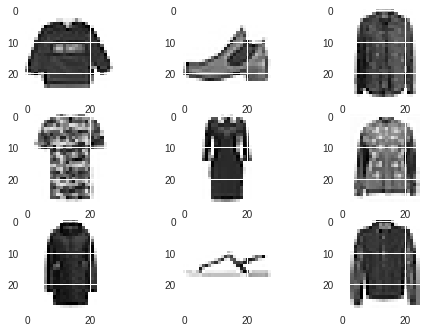

In [0]:
images_to_display = 9

for i in range(0, images_to_display):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i].reshape(28, 28), cmap=pyplot.get_cmap('Greys'))

We will augment our training  images in a few ways.

First we will add a random zoom in / zoom out. We will also flip the images horizontally. 

We do not need to flip them veritcally or apply a rotation since the images in the test dataset are already oriented properly. 

We will also apply a random amount of brightness modification and a random vertical / horizontal shift. 

Lastly we will augment both the training and validation data with a rescale of 1/255 to normallize the data since all pixel values are between 0-255.

We then plot a few images so we can compare the differences of the augmented images with the un-agumented training data.

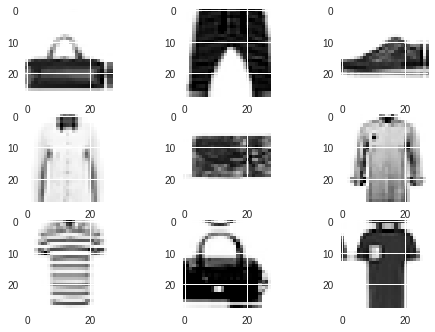

In [0]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255, # normalize images
    shear_range=0.2,
    zoom_range=[0.85, 1.20], # zoom in / out of images
    horizontal_flip=True, # flip horizontally
    vertical_flip=False, # do not flip vertically
    fill_mode='reflect',
    brightness_range=[0.85, 1.20], # adjust the brightness
    width_shift_range=0.1, # shift horizontally
    height_shift_range=0.1, # shift vertically
)

# for test data we just want to rescale
testing_datagen = ImageDataGenerator(rescale=1. / 255)

training_generator = training_datagen.flow(X_train, y_train,
                                     batch_size=batch_size)

validation_generator = testing_datagen.flow(X_train, y_train,
                                     batch_size=batch_size)

images_to_display = 9

# show sample of augmented images
for X_batch, y_batch in training_datagen.flow(X_train, y_train, batch_size=images_to_display):
	# create a grid of 3x3 images
	for i in range(0, images_to_display):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('Greys'))
	# show the plot
	pyplot.show()
	break

Then we build our model using a combination of different layers.

We start with a Convolutional layer with 32 feature maps of size 3 x 3. We also use the relu activation function to add some non-linearity to our network.

We then use another Convolutional layer but this time with 64 feature maps of size 3 x 3.

We then use a MaxPooling layer that takes the maximum value using a Pool size of 2 x 2.

We then add a dropout layer of 25% to help prevent overfitting.

We then add a flatten layer.

We then add a dense (fully connected) layer that again uses the rectifier activation function.

We then use another dropout layer to again help prevent overfitting to the training data.

Finally we add the output layer which is a dense layer with 10 nuerons that uses the softmax activation function.

We then compile the model using the the categorical_crossentropy loss function since we are using catigorical data that has been one-hot encoded into a vector that is all zero except for a 1 at the index of its class.

Lastly we output a summary of our model to make sure it is implemented as described.

In [0]:
# Model
model = Sequential()

# Convolutional layer with 32 feature maps of size 3 x 3
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

# Convolutional layer with 64 feature maps of size 3 x 3
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))

# Pooling layer taking the max over 2 x 2 patches.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout 1/4 to prevent overfitting
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

# 128 neurons Dense layer with using rectifier activation.
model.add(Dense(128, activation='relu'))

# Dropout 1/2 to prevent overfitting
model.add(Dropout(0.5))

# Output layer using softmax
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

We then train our data using the randomly augmented images.

In [0]:
model.fit_generator(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(count_training // batch_size),
                        validation_data=validation_generator,
                        validation_steps=count_testing // batch_size,
                        workers=4)

Epoch 1/25
468/468 [==============================] - 65s 140ms/step - loss: 0.8251 - acc: 0.6996 - val_loss: 0.4323 - val_acc: 0.8421
Epoch 2/25
468/468 [==============================] - 62s 133ms/step - loss: 0.5921 - acc: 0.7805 - val_loss: 0.3920 - val_acc: 0.8505
Epoch 3/25
468/468 [==============================] - 63s 135ms/step - loss: 0.5387 - acc: 0.8026 - val_loss: 0.3537 - val_acc: 0.8696
Epoch 4/25
468/468 [==============================] - 63s 135ms/step - loss: 0.4991 - acc: 0.8164 - val_loss: 0.3345 - val_acc: 0.8725
Epoch 5/25
468/468 [==============================] - 63s 135ms/step - loss: 0.4753 - acc: 0.8254 - val_loss: 0.3260 - val_acc: 0.8788
Epoch 6/25
468/468 [==============================] - 64s 136ms/step - loss: 0.4581 - acc: 0.8311 - val_loss: 0.3121 - val_acc: 0.8786
Epoch 7/25
468/468 [==============================] - 64s 136ms/step - loss: 0.4417 - acc: 0.8365 - val_loss: 0.2779 - val_acc: 0.8985
Epoch 8/25
468/468 [==============================] - 6

After training we can evaluate our model using the test data to see our loss and accuracy scores.

In [0]:
# rescale the test data before evaluating the model
X_test_rescaled = X_test / 255

score = model.evaluate(X_test_rescaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2333637446641922
Test accuracy: 0.9161
